In [1]:
import pyb

/Users/z/PycharmProjects/pyb/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [4]:
import pandas as pd

In [16]:
import numpy as np

In [3]:
stocks_info = pyb.get_stock_info_dataframe()

In [37]:
def filter_by_ipo_date(candlestick_df: pd.DataFrame, stock_info_df: pd.DataFrame) -> pd.DataFrame:
    """
    Filters out (sets to NaN) all close prices in candlestick_df that occur before the IPO date of each stock.
    Afterwards, forward fills missing prices using the previous valid value along the date index.
    
    Parameters:
        candlestick_df (pd.DataFrame): A pivot table with dates as the index and stock codes as columns.
        stock_info_df (pd.DataFrame): A DataFrame containing stock information, including 'stockCode' and 'ipoDate'.
        
    Returns:
        pd.DataFrame: A new DataFrame where prices dated before the IPO date for each stock have been removed,
                      and missing prices are forward filled with the last valid price.
    """
    # Create a copy to avoid modifying the original DataFrame
    filtered_df = candlestick_df.copy()
    
    # Ensure that the 'ipoDate' column is in datetime format
    stock_info_df = stock_info_df.copy()  # avoid modifying the original stock_info_df
    stock_info_df['ipoDate'] = pd.to_datetime(stock_info_df['ipoDate'])
    
    # Iterate over each stock (column) in the candlestick DataFrame
    for stock in filtered_df.columns:
        # Check if the stock code exists in the stock_info DataFrame
        if stock in stock_info_df['stockCode'].values:
            # Get the IPO date for this stock
            ipo_date = stock_info_df.loc[stock_info_df['stockCode'] == stock, 'ipoDate'].iloc[0]
            # Set all prices before the IPO date to NaN
            filtered_df.loc[filtered_df.index < ipo_date, stock] = np.nan

    # Forward fill the prices along the date index (assumes the index is sorted chronologically)
    filtered_df = filtered_df.fillna(method='ffill')
    
    return filtered_df


In [60]:
def filter_factors_by_first_close(close_df, factor_df):
    """
    Filter factor DataFrame by setting values to NaN for dates before first close price exists.
    
    Parameters:
    -----------
    close_df : pandas.DataFrame
        DataFrame containing close prices with stock codes as columns and dates as index
    factor_df : pandas.DataFrame
        DataFrame containing factor values with same structure as close_df
    
    Returns:
    --------
    pandas.DataFrame
        Filtered factor DataFrame with values set to NaN before first close date for each stock
    """
    import pandas as pd
    import numpy as np
    
    # Create a copy of factor_df to avoid modifying the original
    filtered_factor_df = factor_df.copy()
    
    # Get the first non-NaN date for each stock in close_df
    first_close_dates = {}
    for column in close_df.columns:
        if column in factor_df.columns:  # Only process columns that exist in both DataFrames
            non_nan_idx = close_df[column].first_valid_index()
            if non_nan_idx is not None:
                first_close_dates[column] = non_nan_idx
    
    # Filter factor_df based on first close dates
    for stock_code, first_date in first_close_dates.items():
        # Get all dates before the first close price date
        mask = factor_df.index < first_date
        # Set those values to NaN
        filtered_factor_df.loc[mask, stock_code] = np.nan
    
    return filtered_factor_df

In [6]:
ah_stocks = pyb.get_ah_stock_codes()

In [7]:
# pyb.download_candlestick_data(stock_codes=ah_stocks, start_date='2015-01-01', end_date='2024-12-31', candlestick_dir='./data/candlestick_data')

In [8]:
close_df = pyb.get_candlestick_data(symbols=ah_stocks, output_format='bt', candlestick_dir="./data/candlestick_data")

In [38]:
close_df_filtered = filter_by_ipo_date(close_df, stocks_info)

/var/folders/x0/tdjcrtbd1w50yxp0062l_w200000gn/T/ipykernel_72500/2112555777.py:19: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  stock_info_df['ipoDate'] = pd.to_datetime(stock_info_df['ipoDate'])
/var/folders/x0/tdjcrtbd1w50yxp0062l_w200000gn/T/ipykernel_72500/2112555777.py:31: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  filtered_df = filtered_df.fillna(method='ffill')


In [19]:
pb_df = pyb.get_fundamental_data(symbols=ah_stocks, ratio='pb', output_format='bt')


record is  {'date': '2018-09-14T00:00:00+08:00', 'stockCode': '00256'}
record is  {'date': '2018-09-13T00:00:00+08:00', 'stockCode': '00256'}
record is  {'date': '2016-11-28T00:00:00+08:00', 'stockCode': '00256'}
record is  {'date': '2016-04-06T00:00:00+08:00', 'stockCode': '00256'}
record is  {'date': '2016-04-05T00:00:00+08:00', 'stockCode': '00256'}
record is  {'date': '2016-04-01T00:00:00+08:00', 'stockCode': '00256'}
record is  {'date': '2016-03-31T00:00:00+08:00', 'stockCode': '00256'}
record is  {'date': '2016-03-30T00:00:00+08:00', 'stockCode': '00256'}
record is  {'date': '2016-03-29T00:00:00+08:00', 'stockCode': '00256'}
record is  {'date': '2023-01-30T00:00:00+08:00', 'ta': 1484100, 'stockCode': '00314'}
record is  {'date': '2023-01-27T00:00:00+08:00', 'ta': 1510400, 'stockCode': '00314'}
record is  {'date': '2023-01-26T00:00:00+08:00', 'ta': 1380600, 'stockCode': '00314'}
record is  {'date': '2023-01-20T00:00:00+08:00', 'ta': 1041100, 'stockCode': '00314'}
record is  {'date

In [61]:
pb_df_filtered = filter_factors_by_first_close(close_df_filtered, pb_df)

## BT backtest

In [26]:
import matplotlib.pyplot as plt
import bt

In [76]:
available_stocks_log = {}

class LogAvailableStocks(bt.Algo):
    def __init__(self, store_dict):
        super(LogAvailableStocks, self).__init__()
        self.store_dict = store_dict

    def __call__(self, target):
        """
        target.data is a DataFrame of prices (rows=dates, columns=tickers).
        target.now is the current date the strategy is processing.

        We'll count how many columns (tickers) have a non-NA price on this date.
        """
        # Extract the row of data for target.now
        row = target.data.loc[target.now]

        # Count how many tickers have valid (non-NaN) price
        num_available = row.dropna().shape[0]

        # Record it in the dictionary
        print(num_available, target.now)
        self.store_dict[target.now] = num_available

        return True


class SelectTopK(bt.AlgoStack):
    def __init__(self, signal, K, sort_descending=True, all_or_none=False, filter_selected=True):
        super(SelectTopK, self).__init__(bt.algos.SetStat(signal),
                                         bt.algos.SelectN(K, sort_descending, all_or_none, filter_selected))

s = bt.Strategy('ah_premium', [               
                       bt.algos.RunMonthly(run_on_first_date=False),
                       LogAvailableStocks(available_stocks_log), 
                       SelectTopK(pb_df_filtered, K=50, sort_descending=False),
                       bt.algos.WeighEqually(),
                       bt.algos.Rebalance()])


In [77]:

# 创建回测
bkts = bt.Backtest(s, close_df_filtered, integer_positions=False, commissions = lambda q, p: abs(q)*p*0.01)
res = bt.run(bkts)


  0%|          | 0/1 [00:00<?, ?it/s]

6 2015-02-02 00:00:00+08:00
6 2015-03-02 00:00:00+08:00
6 2015-04-01 00:00:00+08:00
6 2015-05-04 00:00:00+08:00
6 2015-06-01 00:00:00+08:00
6 2015-07-02 00:00:00+08:00
6 2015-08-03 00:00:00+08:00
6 2015-09-01 00:00:00+08:00
6 2015-10-02 00:00:00+08:00
6 2015-11-02 00:00:00+08:00
6 2015-12-01 00:00:00+08:00
6 2016-01-04 00:00:00+08:00
6 2016-02-01 00:00:00+08:00
6 2016-03-01 00:00:00+08:00
6 2016-04-01 00:00:00+08:00
6 2016-05-03 00:00:00+08:00
6 2016-06-01 00:00:00+08:00
6 2016-07-04 00:00:00+08:00
6 2016-08-01 00:00:00+08:00
6 2016-09-01 00:00:00+08:00
6 2016-10-03 00:00:00+08:00
6 2016-11-01 00:00:00+08:00
6 2016-12-01 00:00:00+08:00
6 2017-01-03 00:00:00+08:00
6 2017-02-01 00:00:00+08:00
6 2017-03-01 00:00:00+08:00
6 2017-04-03 00:00:00+08:00
6 2017-05-02 00:00:00+08:00
6 2017-06-01 00:00:00+08:00
6 2017-07-03 00:00:00+08:00
6 2017-08-01 00:00:00+08:00
6 2017-09-01 00:00:00+08:00
6 2017-10-03 00:00:00+08:00
6 2017-11-01 00:00:00+08:00
6 2017-12-01 00:00:00+08:00
6 2018-01-02 00:00:0

100%|██████████| 1/1 [00:00<00:00,  1.23it/s]

6 2022-10-03 00:00:00+08:00
6 2022-11-01 00:00:00+08:00
6 2022-12-01 00:00:00+08:00
6 2023-01-03 00:00:00+08:00
6 2023-02-01 00:00:00+08:00
6 2023-03-01 00:00:00+08:00
6 2023-04-03 00:00:00+08:00
6 2023-05-02 00:00:00+08:00
6 2023-06-01 00:00:00+08:00
6 2023-07-03 00:00:00+08:00
6 2023-08-01 00:00:00+08:00
6 2023-09-01 00:00:00+08:00
6 2023-10-03 00:00:00+08:00
6 2023-11-01 00:00:00+08:00
6 2023-12-01 00:00:00+08:00
6 2024-01-02 00:00:00+08:00
6 2024-02-01 00:00:00+08:00
6 2024-03-01 00:00:00+08:00
6 2024-04-02 00:00:00+08:00
6 2024-05-02 00:00:00+08:00
6 2024-06-03 00:00:00+08:00
6 2024-07-02 00:00:00+08:00
6 2024-08-01 00:00:00+08:00
6 2024-09-02 00:00:00+08:00
6 2024-10-02 00:00:00+08:00
6 2024-11-01 00:00:00+08:00
6 2024-12-02 00:00:00+08:00


In [70]:
 # Define the stock code and date to check
stock_code = "01880"
date_to_check = pd.Timestamp("2015-02-02 00:00:00+08:00")

# Check if the date exists in the DataFrame's index and the stock exists in the columns
if date_to_check in close_df_filtered.index:
    if stock_code in close_df_filtered.columns:
        price = close_df_filtered.loc[date_to_check, stock_code]
        print(f"Price for stock {stock_code} on {date_to_check}: {price}")
    else:
        print(f"Stock code {stock_code} not found in the DataFrame columns.")
else:
    print(f"Date {date_to_check} not found in the DataFrame index.")

Price for stock 01880 on 2015-02-02 00:00:00+08:00: nan


In [71]:
close_df_filtered.loc[:, stock_code].to_csv('close_df_filtered.csv')

In [72]:
pb_df_filtered.loc[:, stock_code].to_csv('pb_df.csv')

In [73]:
close_df_filtered.loc[date_to_check, stock_code]

np.float64(nan)

In [ ]:
close_df_filtered.loc[date_to_check, stock_code]

In [44]:
close_df_filtered_fillna = close_df_filtered.ffill()

In [50]:
close_df_filtered.ffill(inplace=True)

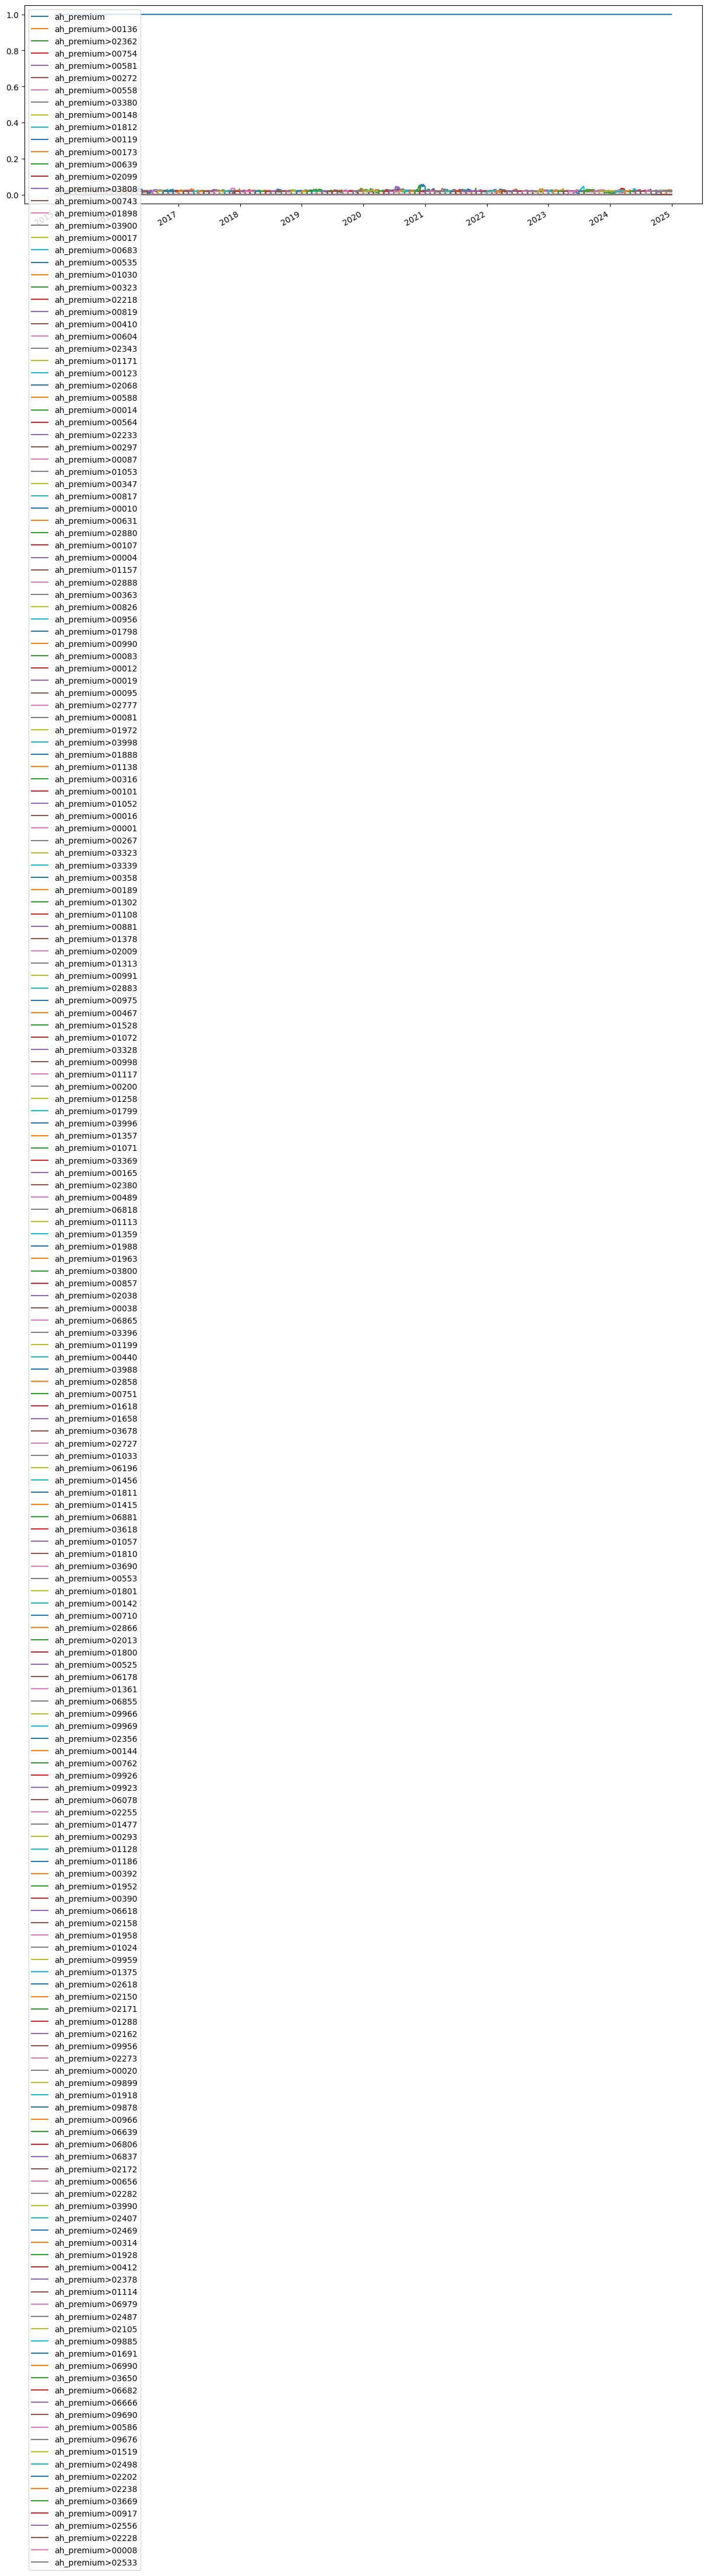

In [78]:
res.plot_weights()

/Users/z/PycharmProjects/pyb/.venv/lib/python3.9/site-packages/bt/backtest.py:347: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  outlays = s.outlays
/Users/z/PycharmProjects/pyb/.venv/lib/python3.9/site-packages/bt/backtest.py:347: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  outlays = s.outlays
/Users/z/PycharmProjects/pyb/.venv/lib/python3.9/site-packages/bt/backtest.py:347: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consid

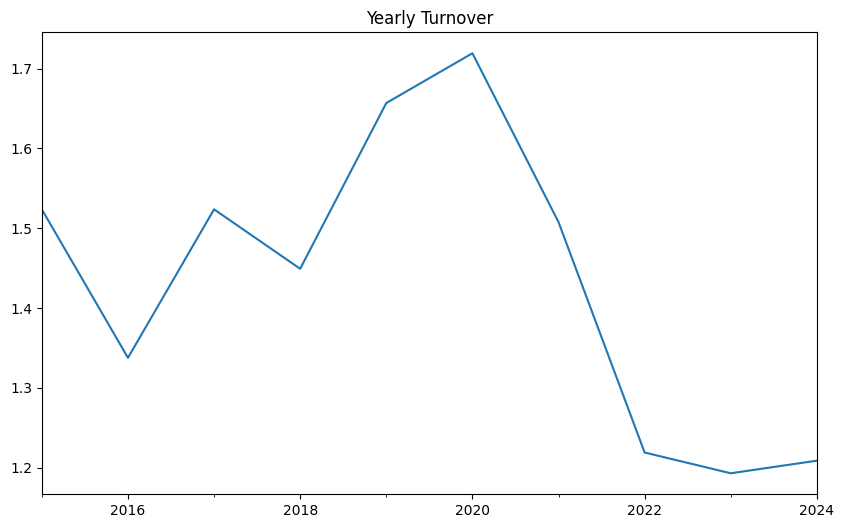

Stat                 ah_premium
-------------------  ------------
Start                2015-01-01
End                  2024-12-31
Risk-free rate       0.00%

Total Return         116.44%
Daily Sharpe         0.53
Daily Sortino        0.86
CAGR                 8.03%
Max Drawdown         -38.71%
Calmar Ratio         0.21

MTD                  1.73%
3m                   -0.84%
6m                   13.57%
YTD                  12.70%
1Y                   12.70%
3Y (ann.)            2.64%
5Y (ann.)            5.02%
10Y (ann.)           8.03%
Since Incep. (ann.)  8.03%

Daily Sharpe         0.53
Daily Sortino        0.86
Daily Mean (ann.)    9.54%
Daily Vol (ann.)     18.11%
Daily Skew           0.02
Daily Kurt           7.27
Best Day             9.12%
Worst Day            -8.04%

Monthly Sharpe       0.47
Monthly Sortino      0.92
Monthly Mean (ann.)  9.92%
Monthly Vol (ann.)   20.93%
Monthly Skew         0.74
Monthly Kurt         3.18
Best Month           27.59%
Worst Month          -14.75%

<Axes: title={'center': 'Equity Progression'}>

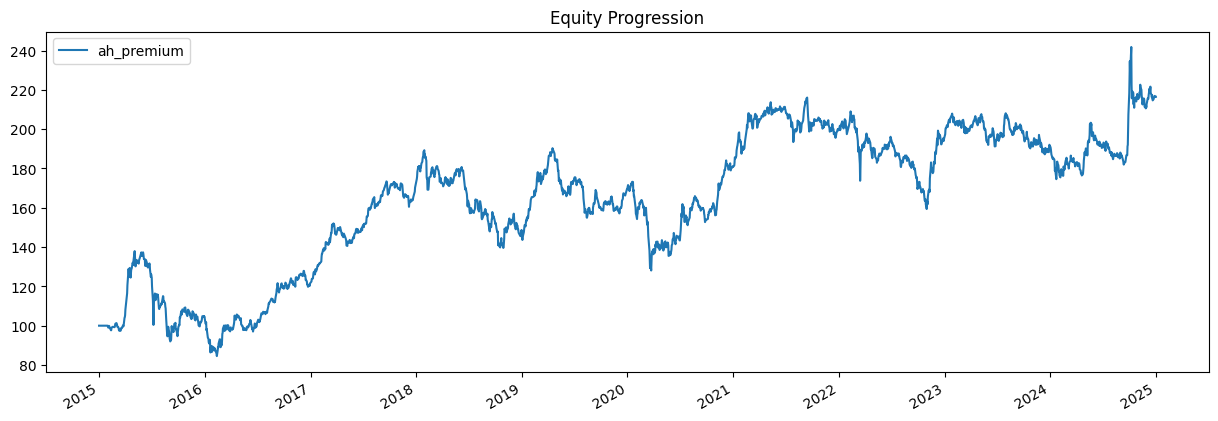

In [79]:

# After the run
turnover_series = bkts.turnover  # or bkts.turnover()
yearly_turnover = turnover_series.resample('YE').sum()
yearly_turnover.plot(title='Yearly Turnover', figsize=(10, 6))
plt.show()
res.display()
res.plot()